# Multivariate time series forecasting

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

# Plots
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 12, 5

# FEDOT framework
from fedot.core.data.data import InputData
from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams
from fedot.core.data.data_split import train_test_data_setup

import warnings

In [2]:
df = pd.read_csv("data\\waves_mod.csv")
df.head(2)

,Hsig,RTpeak,PkDir,Hsig_distanced
0,0.03720,2.0523,45.0,0.022798
1,0.02223,2.0523,25.0,0.016980


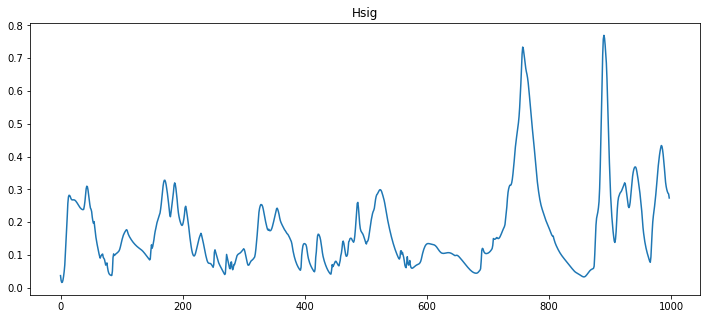

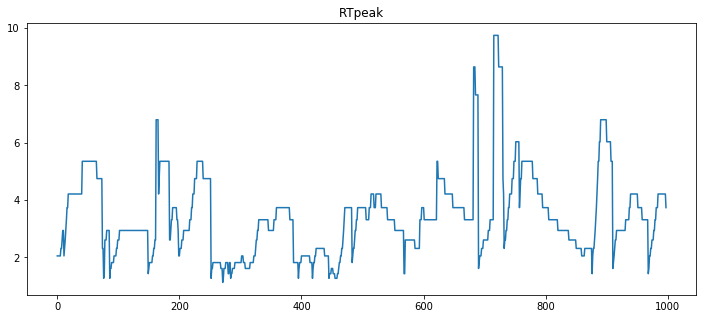

In [3]:
for column in ['Hsig', 'RTpeak']:
    df[column].plot(title=column)
    plt.show()

## Univariate forecasting

In [56]:
# Data preprocessing for FEDOT
def wrap_into_input(forecast_length, feature_time_series, target_time_series):
    """ Convert data for FEDOT framework """
    task = Task(TaskTypesEnum.ts_forecasting,
                TsForecastingParams(forecast_length=forecast_length))
    
    input_data = InputData(idx=np.arange(0, len(target_time_series)),
                           features=feature_time_series, target=target_time_series,
                           task=task, data_type=DataTypesEnum.ts)
    
    return input_data

forecast_length = 200

ts_1 = wrap_into_input(forecast_length=forecast_length, 
                       feature_time_series=np.array(df['Hsig']),
                       target_time_series=np.array(df['Hsig']))

train_ts, test_ts = train_test_data_setup(ts_1)

In [57]:
def simple_linear_pipeline():
    """ Pipeline lagged -> ridge """
    lagged_node = PrimaryNode('lagged')  
    ridge_node = SecondaryNode('ridge', nodes_from=[lagged_node])
    return Pipeline(ridge_node)

simple_pipeline = simple_linear_pipeline()
simple_pipeline.fit(train_ts)
forecast = simple_pipeline.predict(test_ts)

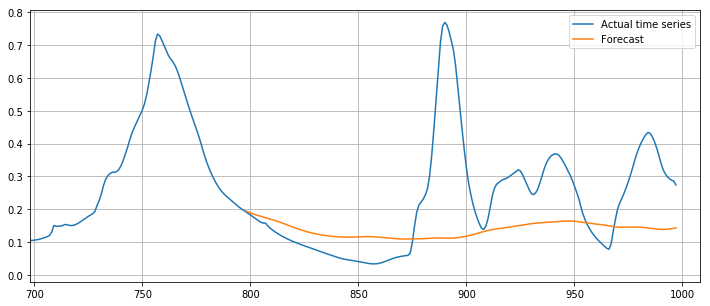

In [58]:
train_length = len(df['Hsig']) - forecast_length

plt.plot(df['Hsig'], label='Actual time series')
plt.plot(np.arange(train_length, train_length + forecast_length), 
         np.ravel(forecast.predict), label='Forecast')
plt.xlim(train_length - 100, len(df['Hsig']) + 10)
plt.legend()
plt.grid()
plt.show()

## Multivariate forecasting

In [59]:
from fedot.core.data.multi_modal import MultiModalData

ts_2 = wrap_into_input(forecast_length=forecast_length, 
                       feature_time_series=np.array(df['RTpeak']),
                       target_time_series=np.array(df['Hsig']))

dataset = MultiModalData({
    'data_source_ts/Hsig': ts_1,
    'data_source_ts/RTpeak': ts_2
})

In [60]:
train, test = train_test_data_setup(dataset)

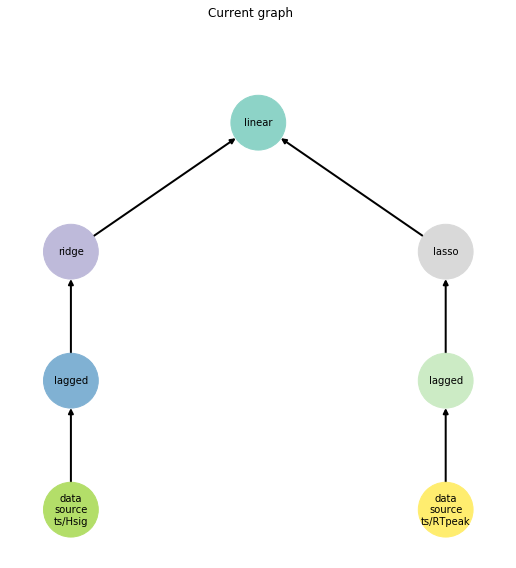

In [111]:
def create_multisource_pipeline():
    """ Generate pipeline with data several data sources """
    node_source_1 = PrimaryNode('data_source_ts/Hsig')
    node_source_2 = PrimaryNode('data_source_ts/RTpeak')

    node_lagged_1 = SecondaryNode('lagged', nodes_from=[node_source_1])
    node_lagged_1.custom_params = {'window_size': 150}
    node_lagged_2 = SecondaryNode('lagged', nodes_from=[node_source_2])
    node_lagged_2.custom_params = {'window_size': 15}

    node_ridge_1 = SecondaryNode('ridge', nodes_from=[node_lagged_1])
    node_ridge_2 = SecondaryNode('lasso', nodes_from=[node_lagged_2])
    
    node_final = SecondaryNode('linear', nodes_from=[node_ridge_1, node_ridge_2])
    pipeline = Pipeline(node_final)
    return pipeline

pipeline = create_multisource_pipeline()
pipeline.show()

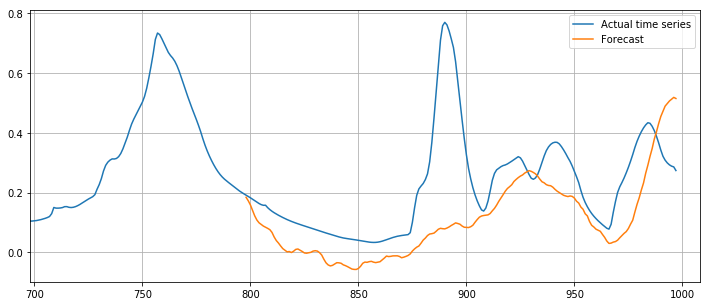

In [112]:
pipeline.fit(train)
forecast = pipeline.predict(test)

train_length = len(df['Hsig']) - forecast_length

plt.plot(df['Hsig'], label='Actual time series')
plt.plot(np.arange(train_length, train_length + forecast_length), 
         np.ravel(forecast.predict), label='Forecast')
plt.xlim(train_length - 100, len(df['Hsig']) + 10)
plt.legend()
plt.grid()
plt.show()